# Rational Speech Act Theory

This notebook implements a simple model from the Rational Speech Act
framework for scalar implicature 
([Goodman & Stuhlmüller](https://onlinelibrary.wiley.com/doi/abs/10.1111/tops.12007)).

In [8]:
from flippy import infer, condition, flip, draw_from
from math import exp, log as log_
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def log(x):
    return log_(x) if x > 0 else float('-inf')

In [10]:
def world_prior():
    return draw_from(4)

def utterance_prior():
    return draw_from(['some', "all", 'none'])

def meaning(utt, world):
    return (
        world > 0 if utt == 'some' else
        world == 3 if utt == 'all' else
        world == 0 if utt == 'none' else
        True
    )

### Scalar implicature with literal listener, literal speaker, and pragmatic listener 

In [ ]:
@infer
def literal_listener(utterance):
    world = world_prior()
    m = meaning(utterance, world)
    condition(m)
    return world

@infer
def literal_speaker(world, rationality=1) -> str:
    utterance = utterance_prior()
    listener_beliefs = literal_listener(utterance)
    true_belief = listener_beliefs.prob(world)
    condition(exp(rationality*log(true_belief)))
    return utterance

@infer
def pragmatic_listener(utterance, speaker_rationality=1):
    world = world_prior()
    speaker_policy = literal_speaker(world, rationality=speaker_rationality)
    speaker_policy.observe(utterance)
    return world

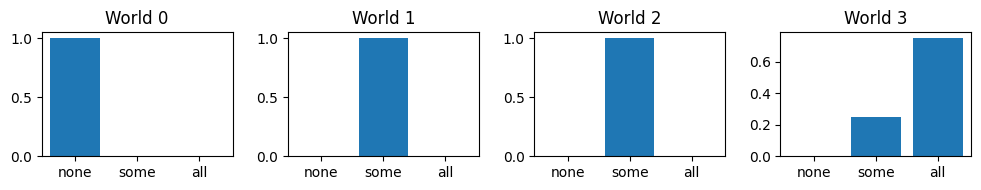

In [12]:
speaker_policy_df = []
fig, axes = plt.subplots(1, 4, figsize=(10, 2))
for ax, w in zip(axes, range(4)):
    speaker_policy = speaker(w, rationality=1)
    ax.bar(['none', 'some', 'all'], 
           [speaker_policy.prob('none'), speaker_policy.prob('some'), speaker_policy.prob('all')])
    ax.set_title(f'World {w}')
fig.tight_layout()

In [13]:
pragmatic_listener("some", speaker_rationality=2)

,Element,Probability
0,2,0.476
1,1,0.476
2,3,0.048


### Scalar implicature with mutually recursive listener and speaker functions

In [20]:
@infer
def listener(utterance, speaker_rationality=1, level=0):
    assert level % 2 == 0, "Level must be even for listener"
    world = world_prior()
    if level <= 0:
        m = meaning(utterance, world)
        condition(m)
        return world
    speaker_policy = speaker(world, rationality=speaker_rationality, level=level-1)
    speaker_policy.observe(utterance)
    return world

@infer
def speaker(world, rationality=1, level=1) -> str:
    assert level % 2 == 1, "Level must be odd for speaker"
    utterance = utterance_prior()
    listener_beliefs = listener(
        utterance,
        speaker_rationality=rationality,
        level=level - 1
    )
    true_belief = listener_beliefs.prob(world)
    condition(exp(rationality*log(true_belief)))
    return utterance


In [46]:
speaker_policy_df = []
for rationality in [.1, .5, 1, 2, 5, 10]:
    for level in range(1, 21, 2):
        policy = speaker(3, rationality=rationality, level=level)
        speaker_policy_df.append({
            'rationality': rationality,
            'level': level,
            **dict(policy),
        })
speaker_policy_df = pd.DataFrame(speaker_policy_df)

<Axes: xlabel='level', ylabel='all'>

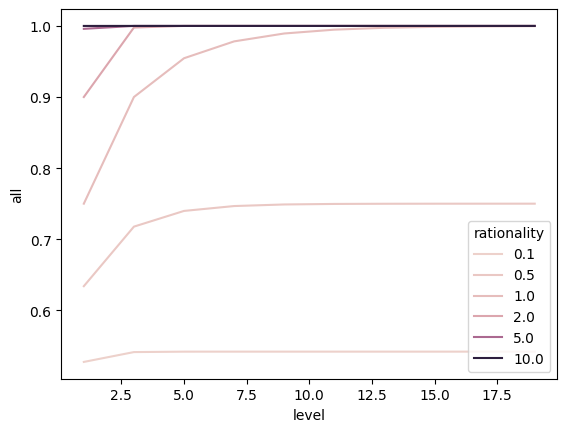

In [47]:
sns.lineplot(
    data=speaker_policy_df,
    x='level',
    y='all',
    hue='rationality',
)

In [52]:
# listener("some", speaker_rationality=2, level=2)
listener_inference_df = []
for rationality in [.1, .5, 1, 2, 5, 10]:
    for level in range(0, 21, 2):
        world_dist = listener("some", speaker_rationality=rationality, level=level)
        listener_inference_df.append({
            'rationality': rationality,
            'level': level,
            **dict(world_dist)
        })
listener_inference_df = pd.DataFrame(listener_inference_df)

<Axes: xlabel='level', ylabel='2'>

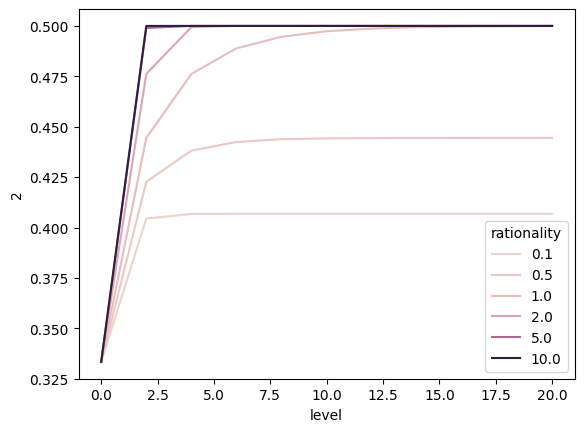

In [56]:
sns.lineplot(
    data=listener_inference_df,
    x='level',
    y=2,
    hue='rationality',
)